# import libary

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import talib as ta
import matplotlib.pyplot as plt

# get data from yahoo finance and add detail

In [2]:
# Load BTC historical data from Yahoo Finance
data = yf.download('BTC-USD', start='2019-01-01', end='2024-11-17') # โหลดข้อมูลมาแล้วระบุวันเริ่มกับวันสุดท้าย

data['Return'] = data['Close'].pct_change() # ทำค่าผลต่างเป็นเปอร์เซ็นจากวันปัจจุบันและวันก่อนหน้า return ก็คือผลตอบแทนที่ดได้จากราคาปิดวันนี้เทียบกับเมื่อวาน
data['Volume_Change'] = data['Volume'].pct_change() # จำนวนหุ้นที่เปลี่ยนแปลงวันต่อวันเป็นเปอร์เซ็น
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return,Volume_Change
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
Date,,,,,,,,
2019-01-01 00:00:00+00:00,3843.520020,3843.520020,3850.913818,3707.231201,3746.713379,4324200990,NaN,NaN
2019-01-02 00:00:00+00:00,3943.409424,3943.409424,3947.981201,3817.409424,3849.216309,5244856836,0.025989,0.212908
2019-01-03 00:00:00+00:00,3836.741211,3836.741211,3935.685059,3826.222900,3931.048584,4530215219,-0.027050,-0.136256
2019-01-04 00:00:00+00:00,3857.717529,3857.717529,3865.934570,3783.853760,3832.040039,4847965467,0.005467,0.070140
2019-01-05 00:00:00+00:00,3845.194580,3845.194580,3904.903076,3836.900146,3851.973877,5137609824,-0.003246,0.059746


In [3]:
# Add more technical indicators
# หา Simple Moving Average ช่วง 10 และ 50 วัน
data['SMA_10'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=10)
data['SMA_50'] = ta.SMA(data['Close'].to_numpy().flatten(), timeperiod=50)

# หา Relative Strength Index ในช่วง 14 วัน
# หาก RSI ต่ำกว่า 30% จะเรียกว่าภาวะ “ขายมากเกินไป” (Oversold)
# หาก RSI สูงกว่า 70% จะเรียกว่าภาวะ “ซื้อมากเกินไป” (Overbought)
data['RSI'] = ta.RSI(data['Close'].to_numpy().flatten(), timeperiod=14)

# หา Moving Average Convergence Divergence ตัว MACD หาได้จากความต่างของ EMA (Exponential Moving Average) สองเส้นหรือ EMA12 - EMA26
# เอาไว้ดูคู่กับ signal line เพื่อประกอบการตัดสินใจจังหวะซื้อหรือขาย
data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'].to_numpy().flatten(), fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands กรอบราคาที่สามารเหวี่ยงไปได้ทั้งกรอบบน กรอบล่าง
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'].to_numpy().flatten(), timeperiod=20)

# หา momentum ซึ่งเป็นอัตราเร่งของราคา
data['Momentum'] = ta.MOM(data['Close'].to_numpy().flatten(), timeperiod=10)

# หาความผันผวนของราคาปิดเมื่อเทียบกับราคาสูงสุดและต่ำสุด
data['Volatility'] = ta.ATR(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), timeperiod=14)  # Added Volatility

# หาค่า Stochastic ออกมาเป็นเปอร์เซ็นเพื่อดูพฤติกรรมการซื้อขาย เพื่อหาจุดที่จะเก็งกำไร ส่วนใหญ่ทำในระยะสั้น
data['Stochastic'] = ta.STOCH(data['High'].to_numpy().flatten(), data['Low'].to_numpy().flatten(), data['Close'].to_numpy().flatten(), fastk_period=14, slowk_period=3)[0]  # Added Stochastic

In [4]:
# Create lag features for capturing trends
# อาจจะทำ lag เพื่อดูตอนย้อนกับปัจจุบัน
# shift ข้อมูลลง 1 row
data['Return_Lag1'] = data['Return'].shift(1)
data['RSI_Lag1'] = data['RSI'].shift(1)
data['SMA_10_Lag1'] = data['SMA_10'].shift(1)
data['SMA_50_Lag1'] = data['SMA_50'].shift(1)

# Drop NaN values after adding new features
data.dropna(inplace=True)

# train model

In [6]:
# Define features and target
features = [
    'Return', 'Volume_Change', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal',
    'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Return_Lag1', 'RSI_Lag1',
    'SMA_10_Lag1', 'SMA_50_Lag1', 'Volatility', 'Stochastic'
]

# แปลง return เป็น 0, 1 สำหรับการทายวันจะขึ้นหรือลงเพื่อทำกำไรด้วยวิธีการ long short
data['Target'] = np.where(data['Return'].shift(-1) > 0, 1, 0)  # 1 for up, 0 for down

# แยก x y สำหรับการ train
X = data[features]
y = data['Target']

# Standardize the features
# สดกลตามค่า z (ภูเขา)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

In [7]:
# Use GridSearchCV to tune hyperparameters for better performance
# พาราเมเตอร์สำหรับการ train
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Train the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

# Make predictions and evaluate on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Cross-Validation Accuracy: 0.43 (+/- 0.07)
Test Accuracy: 0.49


# back test

เพิ่มค่าธรรมเนียม 0.1%
ลองเพิ่ม csv เพื่อดูค่าดิบของการทำงาน
nav ส่วนใหญ่เริ่มต้นที่ 10

In [8]:
# Backtesting with updated features and better portfolio simulation
capital = 10  # Initial capital
capital_history = []

# Map test indices to the original DataFrame
test_indices = y_test.index.to_list() # คาดว่าวันไม่เรียง

# Trade logic with stop-loss and take-profit to reduce risk
for i in range(len(test_indices) - 1):
    current_idx = test_indices[i]
    next_idx = test_indices[i + 1]

    prediction = best_model.predict([X_test[i]])[0]
    price_today = data['Close'].loc[current_idx]["BTC-USD"]
    price_next_day = data['Close'].loc[next_idx]["BTC-USD"]

    # Set stop-loss and take-profit levels
    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.05  # 5% take profit
    # Long position logic (buy if predicted up)
    if prediction == 1:
        profit = (price_next_day - price_today) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered
    else:  # Short position logic (sell if predicted down)
        profit = (price_today - price_next_day) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered

    capital += profit
    capital_history.append(capital)

# เพิ่มเติมฟังก์ชันสำหรับการหา CAGR, Max Drawdown, SD และเพิ่มกับการค่าธรรมเนียม

In [24]:
# Backtesting with updated features and better portfolio simulation
capital = 10000  # Initial capital
capital_history = []

my_dict = {"price_today": [], "price_next_day": [], "prediction": [], "capital": [], "profit": []}

# Map test indices to the original DataFrame
test_indices = y_test.index.to_list() # คาดว่าวันไม่เรียง

# Trade logic with stop-loss and take-profit to reduce risk
for i in range(len(test_indices) - 1):
    current_idx = test_indices[i]
    next_idx = test_indices[i + 1]

    prediction = best_model.predict([X_test[i]])[0]
    price_today = data['Close'].loc[current_idx]["BTC-USD"]
    price_next_day = data['Close'].loc[next_idx]["BTC-USD"]

    # Set stop-loss and take-profit levels
    stop_loss_pct = 0.02  # 2% stop loss
    take_profit_pct = 0.05  # 5% take profit

    capital *= 0.999 # หักค่าธรรมเนีม

    # Long position logic (buy if predicted up)
    if prediction == 1:
        profit = (price_next_day - price_today) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered
    else:  # Short position logic (sell if predicted down)
        profit = (price_today - price_next_day) / price_today * capital
        if profit < -stop_loss_pct * capital:
            profit = -stop_loss_pct * capital  # Stop loss triggered
        elif profit > take_profit_pct * capital:
            profit = take_profit_pct * capital  # Take profit triggered    

    capital += profit
    
    capital *= 0.999

    capital_history.append(capital)
    my_dict["price_today"].append(price_today)
    my_dict["price_next_day"].append(price_next_day)
    my_dict["prediction"].append(prediction)
    my_dict["capital"].append(capital)
    my_dict["profit"].append(profit)

In [10]:
import pandas as pd

df = pd.DataFrame(my_dict)
df.to_csv("all_history.csv", index=False)

ค่าที่ต้องเอาเวลาทำกองทุน
- cagr เป็นรีเทินเฉลี่ยต่อปี สูตรคือ = ( ราคาสุดท้าย / ราคาตั้งต้น )^(1 / จำนวนปี) - 1
- max drarwdown
- sd ความผันผวน

In [ ]:
def cal_cagr(year, history):
    day = 365 * year
    if day < len(history):
        cagr = (history[-1] / history[-day])**(1 / year) - 1
        cagr *= 100
        return cagr
    else:
        print("cant find cagr")
        return 0

print(cal_cagr(1, capital_history))

In [ ]:
def cal_max_drawdown(history):
    max_drawdown = 0
    peak = 0
    index_peak = 0
    index_trough = 0
    index_use_peak = 0
    for i in range(len(history)):
        if history[i] > peak:
            peak = history[i]
            index_peak = i
        else:
            drawdown = (peak - history[i]) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                index_use_peak = index_peak
                index_trough = i
    return max_drawdown, index_use_peak, index_trough

print(cal_max_drawdown(capital_history))

In [ ]:
def cal_sd(history):
    history = np.array(history)
    return np.std(history)

print(cal_sd(capital_history))

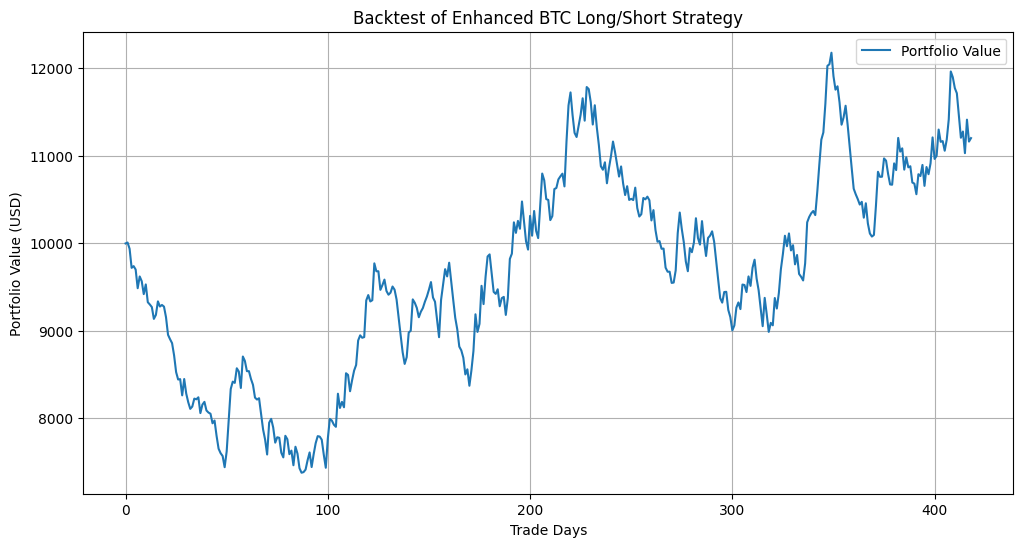

In [25]:
# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(capital_history, label='Portfolio Value')
plt.title('Backtest of Enhanced BTC Long/Short Strategy')
plt.xlabel('Trade Days')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

# เพิ่มเติม
ตัวที่เหมาะกับการเทรดทองมากที่สุดเป็น xau
ส่วนตัวที่ gpt แนะนำมา มันไม่ค่อยดี
ดูไอเดียวเรื่องทองมาหน่อยว่าเป็นไงมั้ง ว่าจะใช้วิธีไหนดี
เวลาเอาเป็น 5 ปีไปดูวิธีการที่จะใช้มาด้วย
train 4 test 1